In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Time Series Cross Validation using the Xgboost Machine Learning Model, as a Modeling Approach and In the cross validation framework, proper consideration was given to removing forward bias. In feature engineering, there were three steps: 1: all features and their seasonal and trend components,. 2: Added several date-related functionality, such as month and quarter. 3: Autoregressive lagged features of the target variable and other lagged features were constructed to represent the sequential nature of time series. The minimum normalised rmse is obtained using the third strategy.

Exploratory data analysis revealed that the target variable has a significant trend, and that variables with comparable trends were also turning up as top features in model feature importance. Features with high seasonality, on the other hand, were not found to be good predictors.

What could have done if you had more time,1: I would have done more feature engineering by using rolling means of features, feature interactions, and other additions by grouping different feature statistics together. 2: The code could be cleaned up and modularized, 3: The model could be improved through hyperparameter tuning, and 4: Other advanced models, such as LSTM, may be used for forecasting.

In [2]:
# Imports #
import numpy as np
import random
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
import pandas as pd
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot


In [3]:
fed_policy = pd.read_csv("/content/drive/My Drive/Micro_Dec_2021/fed_policy.csv")
mortgae = pd.read_csv("/content/drive/My Drive/Micro_Dec_2021/MORTGAGE30US.csv")
seattle_weather = pd.read_csv("/content/drive/My Drive/Micro_Dec_2021/seattle_weather.csv")
sexrsa = pd.read_csv("/content/drive/My Drive/Micro_Dec_2021/SEXRSA.csv")
wana = pd.read_csv("/content/drive/My Drive/Micro_Dec_2021/WANA.csv")
wm2ns = pd.read_csv("/content/drive/My Drive/Micro_Dec_2021/WM2NS.csv")

df = pd.merge(fed_policy,mortgae,on="DATE",how="left")
df = pd.merge(df,wm2ns,on="DATE",how="left")
df = pd.merge(df,wana,on="DATE",how="left")
df = pd.merge(df,sexrsa,on="DATE",how="left")
seattle_weather.DATE = df.iloc[192:,0].ravel()
seattle_weather.drop(['STATION', 'NAME'],axis=1,inplace=True)
df = pd.merge(df,seattle_weather,on="DATE",how="left")

In [4]:
df.head()

,DATE,InflationTargetting,MORTGAGE30US,WM2NS,WANA,SEXRSA,AWND,PRCP,TAVG,TMAX,TMIN
0,1/1/1960,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2/1/1960,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/1/1960,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4/1/1960,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5/1/1960,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

DATE                    object
InflationTargetting     object
MORTGAGE30US           float64
WM2NS                  float64
WANA                   float64
SEXRSA                 float64
AWND                   float64
PRCP                   float64
TAVG                   float64
TMAX                   float64
TMIN                   float64
dtype: object

In [6]:
df.DATE = pd.to_datetime(df.DATE)
df.index = df.DATE
df.drop(["DATE","InflationTargetting"],axis=1,inplace=True)

In [7]:
df.columns

Index(['MORTGAGE30US', 'WM2NS', 'WANA', 'SEXRSA', 'AWND', 'PRCP', 'TAVG',
       'TMAX', 'TMIN'],
      dtype='object')

'WM2NS', 'WANA','SEXRSA':: has similar upward trend 'MORTGAGE30US': has downward trend with time, which is opposite to the target variable trend
'AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN': has a lot of seasonality

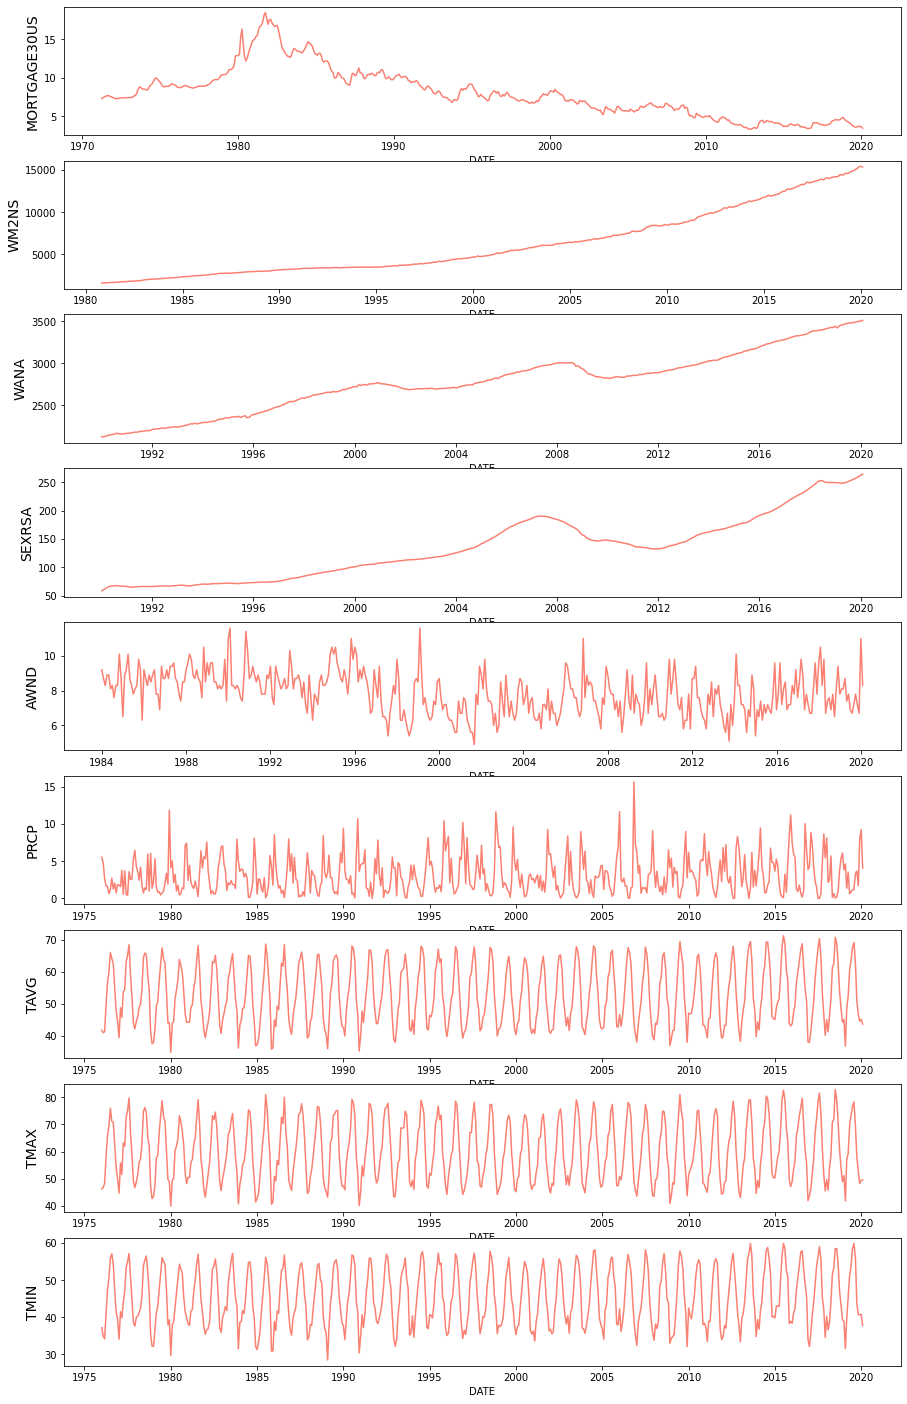

In [8]:
f, ax = plt.subplots(nrows=9, ncols=1, figsize=(15, 25))
for i, column in enumerate(df.columns):
    sns.lineplot(x=df.index, y=df[column], ax=ax[i], color='salmon')
    ax[i].set_ylabel(ylabel=column, fontsize=14)              
   

No Missing Value is present after 1990, which is the starting point of the target variable "Case-Shiller Seattle, WA house price index"
This means we can take lagged version(shifted series of other features without lossing the data)

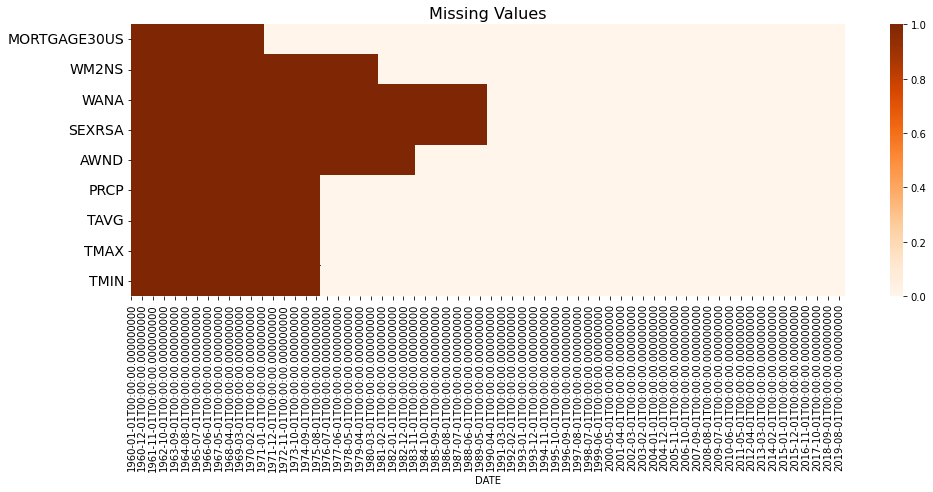

In [9]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Oranges')
ax.set_title('Missing Values', fontsize=16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

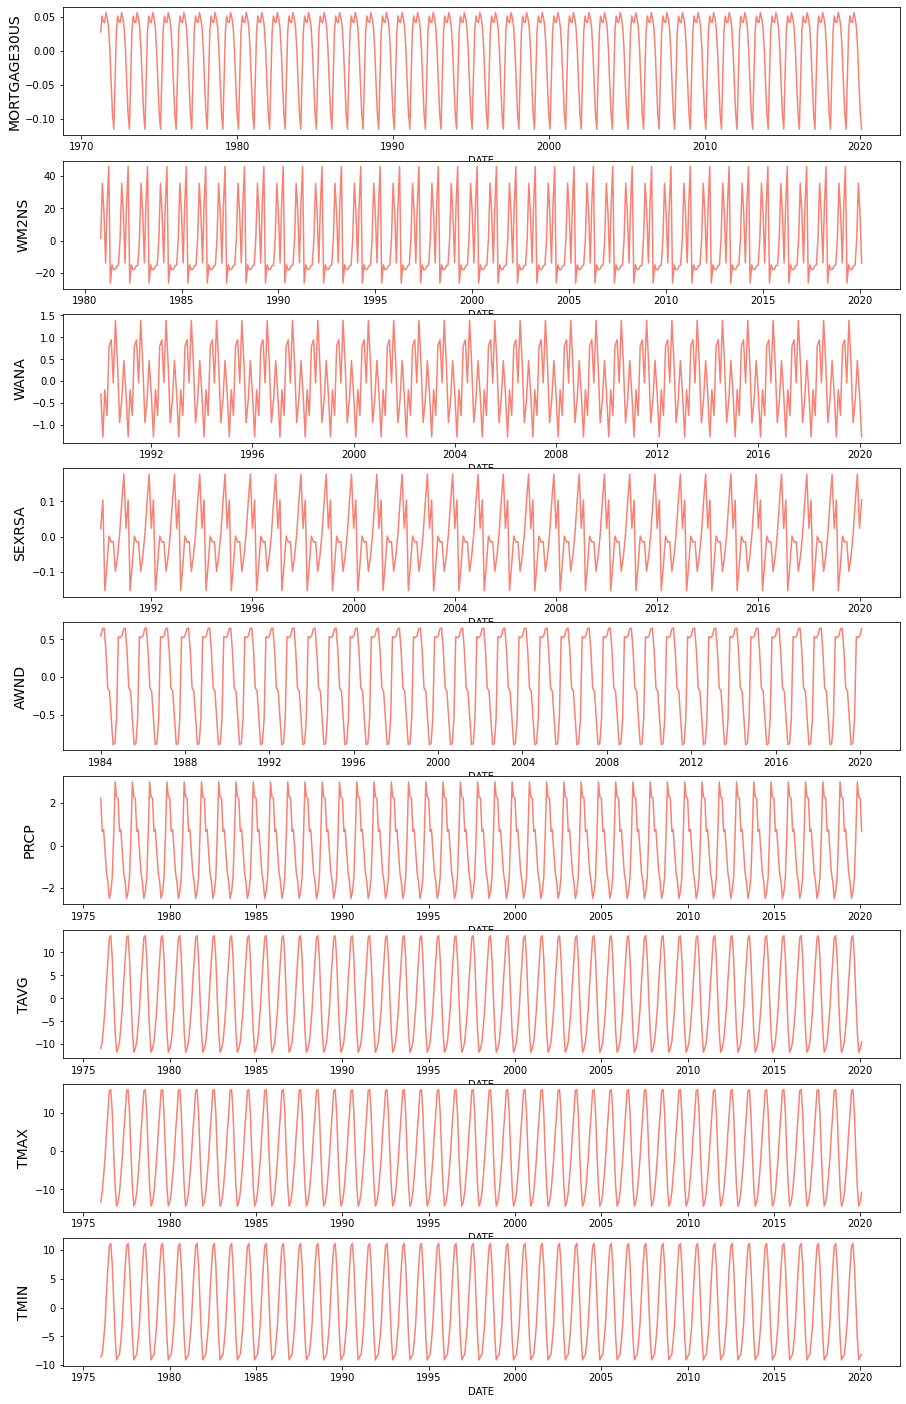

In [10]:
f, ax = plt.subplots(nrows=9, ncols=1, figsize=(15, 25))
for i, column in enumerate(df.columns):
  tmp = df.copy()
  tmp = tmp[pd.notna(df[column])]
  decomp = seasonal_decompose(tmp[column],freq=12,extrapolate_trend='freq')
  df[f"{column}_trend"] = decomp.trend
  df[f"{column}_seasonal"] = decomp.seasonal  
  sns.lineplot(x=df.index, y=df[column + '_seasonal'], ax=ax[i], color='salmon')
  ax[i].set_ylabel(ylabel=column, fontsize=14)  
  df.drop([f"{column}_trend",f"{column}_seasonal"],axis=1,inplace=True)

In [11]:
df.head()

,MORTGAGE30US,WM2NS,WANA,SEXRSA,AWND,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,,,,
1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


High autocorrelation in target varaible for lags lower than 50

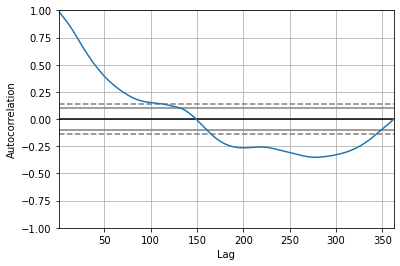

In [12]:
autocorrelation_plot(df[pd.notna(df['SEXRSA'])]["SEXRSA"])
plt.show()

Time Series Cross Validation Framework,

Checking the forecasting validation framework for nrmse, cheking for random predictions

In [13]:
prediction = df[["SEXRSA"]].copy()
df = df.loc[df.index >= "1990-01-01",]
n_train = 330
fhorizon = 12
n_records = df.shape[0]
nrmse_list = []
for i in range(n_train, n_records):
    if(len(df[i-1:i+fhorizon-1])!=12):
        break
    train, test = df[0:i-1], df[i-1:i+fhorizon-1]
    prediction[f"{i}_fold"] = test.SEXRSA  +  random.randint(0,400)
    print(len(test))  
    print(i)
    print('train=%d, test=%d' % (len(train), len(test)))
    accuracy_chk = prediction[["SEXRSA",f"{i}_fold"]].copy()
    accuracy_chk = accuracy_chk.dropna()
    nrmse = (np.sqrt(((accuracy_chk[f"{i}_fold"] - accuracy_chk['SEXRSA']) ** 2).mean())/(accuracy_chk.SEXRSA.mean()))
    nrmse_list.append(nrmse)
    print(np.round(nrmse,5))
print("-----") 
print("Final NRMSE = ",np.mean(nrmse_list))  
print("-----") 

12
330
train=329, test=12
1.2324
12
331
train=330, test=12
0.06686
12
332
train=331, test=12
0.90684
12
333
train=332, test=12
1.01502
12
334
train=333, test=12
1.20423
12
335
train=334, test=12
0.02841
12
336
train=335, test=12
0.42395
12
337
train=336, test=12
0.94897
12
338
train=337, test=12
1.00604
12
339
train=338, test=12
0.5679
12
340
train=339, test=12
1.33413
12
341
train=340, test=12
0.32755
12
342
train=341, test=12
0.06798
12
343
train=342, test=12
1.06481
12
344
train=343, test=12
1.00126
12
345
train=344, test=12
0.6684
12
346
train=345, test=12
0.15187
12
347
train=346, test=12
0.50648
12
348
train=347, test=12
1.5153
12
349
train=348, test=12
0.72931
12
350
train=349, test=12
0.08683
12
351
train=350, test=12
0.84439
-----
Final NRMSE =  0.7135869571339961
-----


In [14]:
prediction.tail(30)

,SEXRSA,330_fold,331_fold,332_fold,333_fold,334_fold,335_fold,336_fold,337_fold,338_fold,339_fold,340_fold,341_fold,342_fold,343_fold,344_fold,345_fold,346_fold,347_fold,348_fold,349_fold,350_fold,351_fold
DATE,,,,,,,,,,,,,,,,,,,,,,,
2017-09-01,230.353347,522.353347,246.353347,449.353347,477.353347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,232.344697,524.344697,248.344697,451.344697,479.344697,527.344697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,234.590071,526.590072,250.590071,453.590072,481.590072,529.590072,241.590071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,237.354354,529.354354,253.354354,456.354354,484.354354,532.354354,244.354354,342.354354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,240.056410,532.056410,256.056410,459.056410,487.056410,535.056410,247.056410,345.056410,476.056410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,242.822173,534.822173,258.822173,461.822173,489.822173,537.822173,249.822173,347.822173,478.822173,493.822173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,245.461531,537.461531,261.461531,464.461531,492.461531,540.461531,252.461531,350.461531,481.461531,496.461531,387.461531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,248.572027,540.572027,264.572027,467.572027,495.572027,543.572027,255.572027,353.572027,484.572027,499.572027,390.572027,582.572027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01,252.109112,544.109112,268.109112,471.109112,499.109112,547.109112,259.109112,357.109112,488.109112,503.109112,394.109112,586.109112,334.109112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.shape

(362, 9)

Defining the parameters for model validation

In [16]:
start = 50
n_train = 300
fhorizon = 12
n_records = df.shape[0]
org_data_cols = df.drop(['SEXRSA'], axis=1).columns

Time Series features are extracted for each validation split in order to ensure that forward bias is not present in the predictions, proper cross validations provides the robustness of model accuracy

In [17]:
prediction = df[["SEXRSA"]].copy()
pred = df[["SEXRSA"]].copy()
nrmse_list = [] ; appended_feature_imp = []

for i in tqdm(range(n_train, n_records)):
    if(len(df[i-1:i+fhorizon-1])!=12):
        break
    train = df.copy()
    start_date = train[start:i].index[-1]
    train = train[start:i-1]    
    for j, column in enumerate(org_data_cols):
        decomp = seasonal_decompose(train[column],freq=12,extrapolate_trend='freq')
        train[f"{column}_trend"] = decomp.trend
        train[f"{column}_seasonal"] = decomp.seasonal

    tmp = train.copy()
    tmp = tmp.append(pred[i-1:i+fhorizon-1].copy()    )
    for col in tmp.drop(['SEXRSA'], axis=1).columns:
        tmp[col] = tmp[col].shift(fhorizon)
    
    test = tmp.tail(fhorizon)
    train = tmp.iloc[fhorizon:-fhorizon]  
    print(i)
    print('train=',train.shape)
    print('test=', test.shape)
    data_cols = train.drop(['SEXRSA'], axis=1).columns   
    data_cols = sorted(data_cols)
    xg = xgb.XGBRegressor(random_state=10,tree_method='gpu_hist')
    eval_set = [(train[data_cols], train.SEXRSA.values.ravel()), (test[data_cols], test.SEXRSA.values.ravel())]
    xg.fit(train[data_cols],train.SEXRSA.values.ravel(), early_stopping_rounds=10, 
         eval_set=eval_set, verbose=False)
    test["predict"] = xg.predict(test[data_cols])
    prediction[f"{i}_fold"] = test["predict"]
    accuracy_chk = prediction[["SEXRSA",f"{i}_fold"]].copy()
    accuracy_chk = accuracy_chk.dropna()
    nrmse = (np.sqrt(((accuracy_chk[f"{i}_fold"] - accuracy_chk['SEXRSA']) ** 2).mean())/(accuracy_chk.SEXRSA.mean()))
    nrmse_list.append(nrmse)
    results=pd.DataFrame()
    results['columns']= data_cols
    results['importances'] = xg.feature_importances_
    appended_feature_imp.append(results)
    del train,test,tmp,results,decomp,column,accuracy_chk

print("-----") 
print("Final NRMSE = ",np.mean(nrmse_list))  
print("-----") 

  0%|          | 0/62 [00:00<?, ?it/s]

300
train= (237, 25)
test= (12, 25)
[18:15:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  2%|▏         | 1/62 [00:01<01:08,  1.13s/it]

301
train= (238, 25)
test= (12, 25)
[18:15:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  3%|▎         | 2/62 [00:02<01:03,  1.06s/it]

302
train= (239, 25)
test= (12, 25)
[18:15:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  5%|▍         | 3/62 [00:03<01:00,  1.02s/it]

303
train= (240, 25)
test= (12, 25)
[18:15:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  6%|▋         | 4/62 [00:04<00:59,  1.02s/it]

304
train= (241, 25)
test= (12, 25)
[18:15:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  8%|▊         | 5/62 [00:05<00:57,  1.01s/it]

305
train= (242, 25)
test= (12, 25)
[18:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 10%|▉         | 6/62 [00:06<00:56,  1.01s/it]

306
train= (243, 25)
test= (12, 25)
[18:15:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 11%|█▏        | 7/62 [00:07<00:55,  1.01s/it]

307
train= (244, 25)
test= (12, 25)
[18:15:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 13%|█▎        | 8/62 [00:08<00:54,  1.01s/it]

308
train= (245, 25)
test= (12, 25)
[18:15:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 15%|█▍        | 9/62 [00:09<00:53,  1.01s/it]

309
train= (246, 25)
test= (12, 25)
[18:15:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 16%|█▌        | 10/62 [00:10<00:52,  1.01s/it]

310
train= (247, 25)
test= (12, 25)
[18:15:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 18%|█▊        | 11/62 [00:11<00:51,  1.02s/it]

311
train= (248, 25)
test= (12, 25)
[18:15:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 19%|█▉        | 12/62 [00:12<00:51,  1.02s/it]

312
train= (249, 25)
test= (12, 25)
[18:15:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 21%|██        | 13/62 [00:13<00:50,  1.03s/it]

313
train= (250, 25)
test= (12, 25)
[18:15:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 23%|██▎       | 14/62 [00:14<00:49,  1.03s/it]

314
train= (251, 25)
test= (12, 25)
[18:15:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 24%|██▍       | 15/62 [00:15<00:48,  1.04s/it]

315
train= (252, 25)
test= (12, 25)
[18:15:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 26%|██▌       | 16/62 [00:16<00:47,  1.04s/it]

316
train= (253, 25)
test= (12, 25)
[18:15:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 27%|██▋       | 17/62 [00:17<00:46,  1.04s/it]

317
train= (254, 25)
test= (12, 25)
[18:15:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 29%|██▉       | 18/62 [00:18<00:45,  1.05s/it]

318
train= (255, 25)
test= (12, 25)
[18:15:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 31%|███       | 19/62 [00:19<00:45,  1.05s/it]

319
train= (256, 25)
test= (12, 25)
[18:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 32%|███▏      | 20/62 [00:20<00:41,  1.01it/s]

320
train= (257, 25)
test= (12, 25)
[18:15:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 34%|███▍      | 21/62 [00:21<00:41,  1.01s/it]

321
train= (258, 25)
test= (12, 25)
[18:15:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 35%|███▌      | 22/62 [00:22<00:41,  1.03s/it]

322
train= (259, 25)
test= (12, 25)
[18:15:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 37%|███▋      | 23/62 [00:23<00:40,  1.04s/it]

323
train= (260, 25)
test= (12, 25)
[18:15:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 39%|███▊      | 24/62 [00:24<00:37,  1.01it/s]

324
train= (261, 25)
test= (12, 25)
[18:15:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 40%|████      | 25/62 [00:25<00:35,  1.04it/s]

325
train= (262, 25)
test= (12, 25)
[18:15:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 42%|████▏     | 26/62 [00:26<00:34,  1.04it/s]

326
train= (263, 25)
test= (12, 25)
[18:15:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 44%|████▎     | 27/62 [00:27<00:32,  1.07it/s]

327
train= (264, 25)
test= (12, 25)
[18:15:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 45%|████▌     | 28/62 [00:28<00:33,  1.03it/s]

328
train= (265, 25)
test= (12, 25)
[18:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 47%|████▋     | 29/62 [00:29<00:33,  1.00s/it]

329
train= (266, 25)
test= (12, 25)
[18:15:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 48%|████▊     | 30/62 [00:30<00:32,  1.00s/it]

330
train= (267, 25)
test= (12, 25)
[18:15:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 50%|█████     | 31/62 [00:31<00:31,  1.03s/it]

331
train= (268, 25)
test= (12, 25)
[18:15:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 52%|█████▏    | 32/62 [00:32<00:31,  1.04s/it]

332
train= (269, 25)
test= (12, 25)
[18:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 53%|█████▎    | 33/62 [00:33<00:30,  1.05s/it]

333
train= (270, 25)
test= (12, 25)
[18:15:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 55%|█████▍    | 34/62 [00:34<00:29,  1.06s/it]

334
train= (271, 25)
test= (12, 25)
[18:15:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 56%|█████▋    | 35/62 [00:35<00:29,  1.08s/it]

335
train= (272, 25)
test= (12, 25)
[18:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 58%|█████▊    | 36/62 [00:36<00:28,  1.08s/it]

336
train= (273, 25)
test= (12, 25)
[18:15:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 60%|█████▉    | 37/62 [00:37<00:27,  1.08s/it]

337
train= (274, 25)
test= (12, 25)
[18:15:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 61%|██████▏   | 38/62 [00:39<00:25,  1.08s/it]

338
train= (275, 25)
test= (12, 25)
[18:15:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 63%|██████▎   | 39/62 [00:40<00:24,  1.08s/it]

339
train= (276, 25)
test= (12, 25)
[18:15:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 65%|██████▍   | 40/62 [00:41<00:23,  1.08s/it]

340
train= (277, 25)
test= (12, 25)
[18:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 66%|██████▌   | 41/62 [00:42<00:22,  1.08s/it]

341
train= (278, 25)
test= (12, 25)
[18:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 68%|██████▊   | 42/62 [00:43<00:21,  1.08s/it]

342
train= (279, 25)
test= (12, 25)
[18:15:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 69%|██████▉   | 43/62 [00:44<00:20,  1.08s/it]

343
train= (280, 25)
test= (12, 25)
[18:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 71%|███████   | 44/62 [00:45<00:19,  1.09s/it]

344
train= (281, 25)
test= (12, 25)
[18:15:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 73%|███████▎  | 45/62 [00:46<00:17,  1.04s/it]

345
train= (282, 25)
test= (12, 25)
[18:15:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 74%|███████▍  | 46/62 [00:47<00:16,  1.02s/it]

346
train= (283, 25)
test= (12, 25)
[18:15:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 76%|███████▌  | 47/62 [00:48<00:15,  1.03s/it]

347
train= (284, 25)
test= (12, 25)
[18:15:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 77%|███████▋  | 48/62 [00:49<00:14,  1.01s/it]

348
train= (285, 25)
test= (12, 25)
[18:15:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 79%|███████▉  | 49/62 [00:50<00:13,  1.01s/it]

349
train= (286, 25)
test= (12, 25)
[18:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 81%|████████  | 50/62 [00:51<00:12,  1.00s/it]

350
train= (287, 25)
test= (12, 25)
[18:15:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 82%|████████▏ | 51/62 [00:52<00:11,  1.03s/it]

351
train= (288, 25)
test= (12, 25)
[18:15:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 84%|████████▍ | 52/62 [00:53<00:10,  1.03s/it]

-----
Final NRMSE =  0.08926519989356357
-----


Final NRMSE =  0.08926519989356357
-----------------

Text(0.5, 1.0, 'XgBoost Imp Vars')

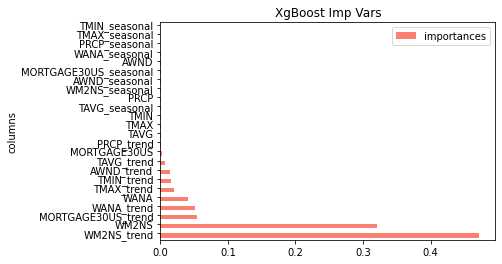

In [18]:
results = pd.concat(appended_feature_imp, axis=0).groupby(['columns'],as_index=False).mean()
results.sort_values(by='importances',ascending=False,inplace=True)
results.plot(colormap='Paired',x="columns", y="importances", kind="barh",fontsize = 10,position = 1,color="Salmon")
plt.title("XgBoost Imp Vars")

Visualize Forecast

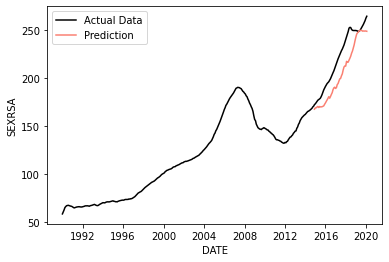

In [19]:
prediction['avg'] = prediction.drop(['SEXRSA'], axis=1).mean(axis=1)
sns.lineplot(x=prediction.index, y=prediction.SEXRSA, color='black', label='Actual Data') 
sns.lineplot(x=prediction.index, y=prediction.avg, color='salmon', label='Prediction') 
plt.show()

Adding Date Time Features to the model

In [20]:
def add_datetime_features(df):
  df["Date"] = df.index
  df['Month'] = df['Date'].dt.month
  df['Quarter'] =df["Date"].dt.quarter
  df['Year'] = df['Date'].dt.year 
  df['Day'] = df['Date'].dt.day 
  df['Week_Number'] = df['Date'].dt.strftime('%V').astype(int)
  df['is_year_start'] = df['Date'].dt.is_year_start
  df['is_quarter_start'] = df['Date'].dt.is_quarter_start
  df['is_month_start'] = df['Date'].dt.is_month_start
  df['is_month_end'] = df['Date'].dt.is_month_end
  df['is_weekend'] = np.where(df['Week_Number'].isin([5,6]), 1,0)
  df.drop("Date",axis=1,inplace=True)
  return df

In [21]:
prediction = df[["SEXRSA"]].copy()
pred = df[["SEXRSA"]].copy()
nrmse_list = [] ; appended_feature_imp = []

for i in tqdm(range(n_train, n_records)):
    if(len(df[i-1:i+fhorizon-1])!=12):
        break
    train = df.copy()
    start_date = train[start:i].index[-1]
    train = train[start:i-1]    
    for j, column in enumerate(org_data_cols):
        decomp = seasonal_decompose(train[column],freq=12,extrapolate_trend='freq')
        train[f"{column}_trend"] = decomp.trend
        train[f"{column}_seasonal"] = decomp.seasonal

    tmp = train.copy()
    tmp = tmp.append(pred[i-1:i+fhorizon-1].copy()    )
    for col in tmp.drop(['SEXRSA'], axis=1).columns:
        tmp[col] = tmp[col].shift(fhorizon)
    
    test = tmp.tail(fhorizon); test = add_datetime_features(test)
    train = tmp.iloc[fhorizon:-fhorizon]; train = add_datetime_features(train)

    print(i)
    print('train=',train.shape)
    print('test=', test.shape)
    data_cols = train.drop(['SEXRSA'], axis=1).columns   
    data_cols = sorted(data_cols)
    xg = xgb.XGBRegressor(random_state=10,tree_method='gpu_hist')
    eval_set = [(train[data_cols], train.SEXRSA.values.ravel()), (test[data_cols], test.SEXRSA.values.ravel())]
    xg.fit(train[data_cols],train.SEXRSA.values.ravel(), early_stopping_rounds=10, 
         eval_set=eval_set, verbose=False)
    test["predict"] = xg.predict(test[data_cols])
    prediction[f"{i}_fold"] = test["predict"]
    accuracy_chk = prediction[["SEXRSA",f"{i}_fold"]].copy()
    accuracy_chk = accuracy_chk.dropna()
    nrmse = (np.sqrt(((accuracy_chk[f"{i}_fold"] - accuracy_chk['SEXRSA']) ** 2).mean())/(accuracy_chk.SEXRSA.mean()))
    nrmse_list.append(nrmse)
    results=pd.DataFrame()
    results['columns']= data_cols
    results['importances'] = xg.feature_importances_
    appended_feature_imp.append(results)
    del train,test,tmp,results,decomp,column,accuracy_chk

print("-----") 
print("Final NRMSE = ",np.mean(nrmse_list))  
print("-----") 

  0%|          | 0/62 [00:00<?, ?it/s]

300
train= (237, 35)
test= (12, 35)
[18:15:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  2%|▏         | 1/62 [00:01<01:05,  1.08s/it]

301
train= (238, 35)
test= (12, 35)
[18:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  3%|▎         | 2/62 [00:02<01:04,  1.08s/it]

302
train= (239, 35)
test= (12, 35)
[18:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  5%|▍         | 3/62 [00:03<01:03,  1.08s/it]

303
train= (240, 35)
test= (12, 35)
[18:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  6%|▋         | 4/62 [00:04<01:02,  1.08s/it]

304
train= (241, 35)
test= (12, 35)
[18:16:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  8%|▊         | 5/62 [00:05<01:01,  1.08s/it]

305
train= (242, 35)
test= (12, 35)
[18:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 10%|▉         | 6/62 [00:06<01:00,  1.08s/it]

306
train= (243, 35)
test= (12, 35)
[18:16:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 11%|█▏        | 7/62 [00:07<00:59,  1.08s/it]

307
train= (244, 35)
test= (12, 35)
[18:16:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 13%|█▎        | 8/62 [00:08<00:58,  1.08s/it]

308
train= (245, 35)
test= (12, 35)
[18:16:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 15%|█▍        | 9/62 [00:09<00:57,  1.09s/it]

309
train= (246, 35)
test= (12, 35)
[18:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 16%|█▌        | 10/62 [00:10<00:56,  1.09s/it]

310
train= (247, 35)
test= (12, 35)
[18:16:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 18%|█▊        | 11/62 [00:11<00:55,  1.10s/it]

311
train= (248, 35)
test= (12, 35)
[18:16:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 19%|█▉        | 12/62 [00:13<00:54,  1.10s/it]

312
train= (249, 35)
test= (12, 35)
[18:16:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 21%|██        | 13/62 [00:14<00:53,  1.10s/it]

313
train= (250, 35)
test= (12, 35)
[18:16:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 23%|██▎       | 14/62 [00:15<00:53,  1.11s/it]

314
train= (251, 35)
test= (12, 35)
[18:16:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 24%|██▍       | 15/62 [00:16<00:52,  1.11s/it]

315
train= (252, 35)
test= (12, 35)
[18:16:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 26%|██▌       | 16/62 [00:17<00:51,  1.11s/it]

316
train= (253, 35)
test= (12, 35)
[18:16:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 27%|██▋       | 17/62 [00:18<00:50,  1.11s/it]

317
train= (254, 35)
test= (12, 35)
[18:16:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 29%|██▉       | 18/62 [00:19<00:49,  1.12s/it]

318
train= (255, 35)
test= (12, 35)
[18:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 31%|███       | 19/62 [00:20<00:48,  1.12s/it]

319
train= (256, 35)
test= (12, 35)
[18:16:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 32%|███▏      | 20/62 [00:21<00:44,  1.07s/it]

320
train= (257, 35)
test= (12, 35)
[18:16:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 34%|███▍      | 21/62 [00:22<00:44,  1.09s/it]

321
train= (258, 35)
test= (12, 35)
[18:16:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 35%|███▌      | 22/62 [00:24<00:44,  1.10s/it]

322
train= (259, 35)
test= (12, 35)
[18:16:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 37%|███▋      | 23/62 [00:25<00:43,  1.11s/it]

323
train= (260, 35)
test= (12, 35)
[18:16:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 39%|███▊      | 24/62 [00:26<00:41,  1.10s/it]

324
train= (261, 35)
test= (12, 35)
[18:16:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 40%|████      | 25/62 [00:27<00:39,  1.06s/it]

325
train= (262, 35)
test= (12, 35)
[18:16:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 42%|████▏     | 26/62 [00:28<00:38,  1.06s/it]

326
train= (263, 35)
test= (12, 35)
[18:16:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 44%|████▎     | 27/62 [00:29<00:37,  1.07s/it]

327
train= (264, 35)
test= (12, 35)
[18:16:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 45%|████▌     | 28/62 [00:30<00:37,  1.10s/it]

328
train= (265, 35)
test= (12, 35)
[18:16:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 47%|████▋     | 29/62 [00:31<00:36,  1.11s/it]

329
train= (266, 35)
test= (12, 35)
[18:16:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 48%|████▊     | 30/62 [00:32<00:35,  1.12s/it]

330
train= (267, 35)
test= (12, 35)
[18:16:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 50%|█████     | 31/62 [00:33<00:34,  1.12s/it]

331
train= (268, 35)
test= (12, 35)
[18:16:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 52%|█████▏    | 32/62 [00:35<00:34,  1.14s/it]

332
train= (269, 35)
test= (12, 35)
[18:16:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 53%|█████▎    | 33/62 [00:36<00:33,  1.14s/it]

333
train= (270, 35)
test= (12, 35)
[18:16:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 55%|█████▍    | 34/62 [00:37<00:32,  1.15s/it]

334
train= (271, 35)
test= (12, 35)
[18:16:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 56%|█████▋    | 35/62 [00:38<00:30,  1.14s/it]

335
train= (272, 35)
test= (12, 35)
[18:16:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 58%|█████▊    | 36/62 [00:39<00:29,  1.15s/it]

336
train= (273, 35)
test= (12, 35)
[18:16:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 60%|█████▉    | 37/62 [00:40<00:28,  1.16s/it]

337
train= (274, 35)
test= (12, 35)
[18:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 61%|██████▏   | 38/62 [00:42<00:27,  1.16s/it]

338
train= (275, 35)
test= (12, 35)
[18:16:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 63%|██████▎   | 39/62 [00:43<00:26,  1.16s/it]

339
train= (276, 35)
test= (12, 35)
[18:16:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 65%|██████▍   | 40/62 [00:44<00:25,  1.16s/it]

340
train= (277, 35)
test= (12, 35)
[18:16:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 66%|██████▌   | 41/62 [00:45<00:24,  1.16s/it]

341
train= (278, 35)
test= (12, 35)
[18:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 68%|██████▊   | 42/62 [00:46<00:23,  1.16s/it]

342
train= (279, 35)
test= (12, 35)
[18:16:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 69%|██████▉   | 43/62 [00:47<00:22,  1.17s/it]

343
train= (280, 35)
test= (12, 35)
[18:16:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 71%|███████   | 44/62 [00:49<00:20,  1.17s/it]

344
train= (281, 35)
test= (12, 35)
[18:16:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 73%|███████▎  | 45/62 [00:50<00:18,  1.11s/it]

345
train= (282, 35)
test= (12, 35)
[18:16:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 74%|███████▍  | 46/62 [00:51<00:17,  1.12s/it]

346
train= (283, 35)
test= (12, 35)
[18:16:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 76%|███████▌  | 47/62 [00:52<00:16,  1.12s/it]

347
train= (284, 35)
test= (12, 35)
[18:16:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 77%|███████▋  | 48/62 [00:53<00:15,  1.12s/it]

348
train= (285, 35)
test= (12, 35)
[18:16:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 79%|███████▉  | 49/62 [00:54<00:14,  1.14s/it]

349
train= (286, 35)
test= (12, 35)
[18:16:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 81%|████████  | 50/62 [00:55<00:13,  1.15s/it]

350
train= (287, 35)
test= (12, 35)
[18:16:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 82%|████████▏ | 51/62 [00:56<00:12,  1.13s/it]

351
train= (288, 35)
test= (12, 35)
[18:16:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 84%|████████▍ | 52/62 [00:57<00:11,  1.12s/it]

-----
Final NRMSE =  0.08914398644934941
-----


Text(0.5, 1.0, 'XgBoost Imp Vars')

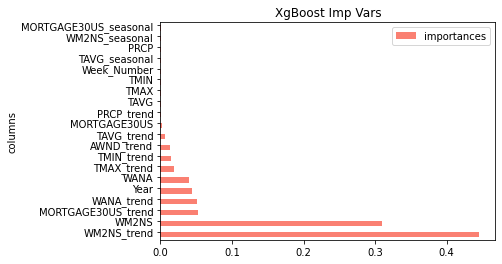

In [22]:
results = pd.concat(appended_feature_imp, axis=0).groupby(['columns'],as_index=False).mean()
results.sort_values(by='importances',ascending=False,inplace=True)
results.iloc[:20,].plot(colormap='Paired',x="columns", y="importances", kind="barh",fontsize = 10,position = 1,color="Salmon")
plt.title("XgBoost Imp Vars")

Final NRMSE =  0.08914398644934941
-----

Visualize the Forecast

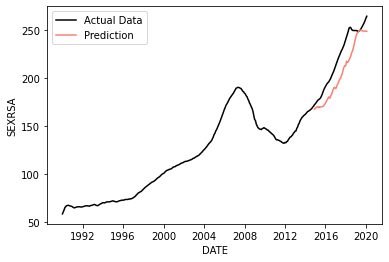

In [23]:
prediction['avg'] = prediction.drop(['SEXRSA'], axis=1).mean(axis=1)
sns.lineplot(x=prediction.index, y=prediction.SEXRSA, color='black', label='Actual Data') 
sns.lineplot(x=prediction.index, y=prediction.avg, color='salmon', label='Prediction') 
plt.show()

Creating More Features from Lagged Time Series

In [24]:
top_features= ['SEXRSA','WM2NS_trend','WM2NS', 'WANA','WANA_trend', 'AWND_trend', 'MORTGAGE30US_trend','TMAX_trend','TMIN_trend']

In [25]:
prediction = df[["SEXRSA"]].copy()
pred = df[["SEXRSA"]].copy()
nrmse_list = [] ; appended_feature_imp = []
lags = [12,13,14,15]

In [26]:
for i in tqdm(range(n_train, n_records)):
    if(len(df[i-1:i+fhorizon-1])!=12):
        break
    train = df.copy()
    train = train[start:i-1]    
    for j, column in enumerate(org_data_cols):
        decomp = seasonal_decompose(train[column],freq=12,extrapolate_trend='freq')
        train[f"{column}_trend"] = decomp.trend
        #train[f"{column}_seasonal"] = decomp.seasonal

    tmp = train.copy()
    tmp = tmp.append(pred[i-1:i+fhorizon-1].copy())
    for col in tmp.drop(['SEXRSA'], axis=1).columns:
        tmp[col] = tmp[col].shift(fhorizon)        
        
    for col in top_features:
        tmp[str(lags[1]) + "lag_" +col] = tmp[col].shift(lags[1])
        tmp[str(lags[2]) + "lag_" +col] = tmp[col].shift(lags[2])
        tmp[str(lags[3]) + "lag_" +col] = tmp[col].shift(lags[3])
        #tmp[str(lags[4]) + "lag_" +col] = tmp[col].shift(lags[4])
        
    ## Autoregressive components    
    for lag in lags:
        tmp[f"{lag}_lag_SEXRSA"] = tmp['SEXRSA'].shift(lag)  

    tmp["12_lag_SEXRSA*WM2NS"]  = tmp['12_lag_SEXRSA']*tmp['WM2NS']
    tmp["12_lag_SEXRSA*15lag_WM2NS"]  = tmp['12_lag_SEXRSA']*tmp['15lag_WM2NS']
    test = tmp.tail(fhorizon); test = add_datetime_features(test)
    train = tmp.iloc[fhorizon:-fhorizon]; train = add_datetime_features(train)
    train = train.dropna()

    print(i)
    print('train=',train.shape)
    print('test=', test.shape)
    data_cols = train.drop(['SEXRSA'], axis=1).columns   
    data_cols = sorted(data_cols)
    xg = xgb.XGBRegressor(random_state=10,tree_method='gpu_hist')
    eval_set = [(train[data_cols], train.SEXRSA.values.ravel()), (test[data_cols], test.SEXRSA.values.ravel())]
    xg.fit(train[data_cols],train.SEXRSA.values.ravel(), early_stopping_rounds=10, 
         eval_set=eval_set, verbose=False)
    xgb_iter = xg.best_iteration
    test["predict"] = xg.predict(test[data_cols])
    prediction[f"{i}_fold"] = test["predict"]
    accuracy_chk = prediction[["SEXRSA",f"{i}_fold"]].copy()
    accuracy_chk = accuracy_chk.dropna()
    nrmse = (np.sqrt(((accuracy_chk[f"{i}_fold"] - accuracy_chk['SEXRSA']) ** 2).mean())/(accuracy_chk.SEXRSA.mean()))
    nrmse_list.append(nrmse)
    results=pd.DataFrame()
    results['columns']= data_cols
    results['importances'] = xg.feature_importances_
    appended_feature_imp.append(results)
    del train,test,tmp,results,decomp,column,accuracy_chk

print("-----") 
print("Final NRMSE = ",np.mean(nrmse_list))  
print("-----") 


  0%|          | 0/62 [00:00<?, ?it/s]

300
train= (222, 60)
test= (12, 60)
[18:16:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  2%|▏         | 1/62 [00:00<00:55,  1.09it/s]

301
train= (223, 60)
test= (12, 60)
[18:16:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  3%|▎         | 2/62 [00:01<00:55,  1.08it/s]

302
train= (224, 60)
test= (12, 60)
[18:16:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  5%|▍         | 3/62 [00:02<00:54,  1.08it/s]

303
train= (225, 60)
test= (12, 60)
[18:16:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  6%|▋         | 4/62 [00:03<00:54,  1.07it/s]

304
train= (226, 60)
test= (12, 60)
[18:16:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  8%|▊         | 5/62 [00:04<00:53,  1.07it/s]

305
train= (227, 60)
test= (12, 60)
[18:16:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 10%|▉         | 6/62 [00:05<00:52,  1.06it/s]

306
train= (228, 60)
test= (12, 60)
[18:17:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 11%|█▏        | 7/62 [00:06<00:51,  1.06it/s]

307
train= (229, 60)
test= (12, 60)
[18:17:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 13%|█▎        | 8/62 [00:07<00:50,  1.07it/s]

308
train= (230, 60)
test= (12, 60)
[18:17:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 15%|█▍        | 9/62 [00:08<00:49,  1.07it/s]

309
train= (231, 60)
test= (12, 60)
[18:17:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 16%|█▌        | 10/62 [00:09<00:48,  1.07it/s]

310
train= (232, 60)
test= (12, 60)
[18:17:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 18%|█▊        | 11/62 [00:10<00:47,  1.06it/s]

311
train= (233, 60)
test= (12, 60)
[18:17:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 19%|█▉        | 12/62 [00:11<00:45,  1.11it/s]

312
train= (234, 60)
test= (12, 60)
[18:17:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 21%|██        | 13/62 [00:12<00:45,  1.08it/s]

313
train= (235, 60)
test= (12, 60)
[18:17:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 23%|██▎       | 14/62 [00:13<00:44,  1.07it/s]

314
train= (236, 60)
test= (12, 60)
[18:17:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 24%|██▍       | 15/62 [00:14<00:44,  1.06it/s]

315
train= (237, 60)
test= (12, 60)
[18:17:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 26%|██▌       | 16/62 [00:14<00:43,  1.05it/s]

316
train= (238, 60)
test= (12, 60)
[18:17:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 27%|██▋       | 17/62 [00:15<00:43,  1.04it/s]

317
train= (239, 60)
test= (12, 60)
[18:17:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 29%|██▉       | 18/62 [00:16<00:42,  1.03it/s]

318
train= (240, 60)
test= (12, 60)
[18:17:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 31%|███       | 19/62 [00:17<00:42,  1.02it/s]

319
train= (241, 60)
test= (12, 60)
[18:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 32%|███▏      | 20/62 [00:18<00:41,  1.02it/s]

320
train= (242, 60)
test= (12, 60)
[18:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 34%|███▍      | 21/62 [00:19<00:40,  1.01it/s]

321
train= (243, 60)
test= (12, 60)
[18:17:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 35%|███▌      | 22/62 [00:20<00:39,  1.01it/s]

322
train= (244, 60)
test= (12, 60)
[18:17:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 37%|███▋      | 23/62 [00:21<00:38,  1.01it/s]

323
train= (245, 60)
test= (12, 60)
[18:17:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 39%|███▊      | 24/62 [00:22<00:37,  1.01it/s]

324
train= (246, 60)
test= (12, 60)
[18:17:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 40%|████      | 25/62 [00:23<00:36,  1.01it/s]

325
train= (247, 60)
test= (12, 60)
[18:17:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 42%|████▏     | 26/62 [00:24<00:36,  1.00s/it]

326
train= (248, 60)
test= (12, 60)
[18:17:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 44%|████▎     | 27/62 [00:25<00:34,  1.03it/s]

327
train= (249, 60)
test= (12, 60)
[18:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 45%|████▌     | 28/62 [00:26<00:33,  1.02it/s]

328
train= (250, 60)
test= (12, 60)
[18:17:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 47%|████▋     | 29/62 [00:27<00:32,  1.01it/s]

329
train= (251, 60)
test= (12, 60)
[18:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 48%|████▊     | 30/62 [00:28<00:32,  1.01s/it]

330
train= (252, 60)
test= (12, 60)
[18:17:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 50%|█████     | 31/62 [00:29<00:30,  1.01it/s]

331
train= (253, 60)
test= (12, 60)
[18:17:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 52%|█████▏    | 32/62 [00:30<00:29,  1.01it/s]

332
train= (254, 60)
test= (12, 60)
[18:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 53%|█████▎    | 33/62 [00:31<00:29,  1.00s/it]

333
train= (255, 60)
test= (12, 60)
[18:17:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 55%|█████▍    | 34/62 [00:32<00:27,  1.01it/s]

334
train= (256, 60)
test= (12, 60)
[18:17:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 56%|█████▋    | 35/62 [00:33<00:27,  1.01s/it]

335
train= (257, 60)
test= (12, 60)
[18:17:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 58%|█████▊    | 36/62 [00:34<00:26,  1.02s/it]

336
train= (258, 60)
test= (12, 60)
[18:17:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 60%|█████▉    | 37/62 [00:35<00:25,  1.02s/it]

337
train= (259, 60)
test= (12, 60)
[18:17:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 61%|██████▏   | 38/62 [00:36<00:24,  1.03s/it]

338
train= (260, 60)
test= (12, 60)
[18:17:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 63%|██████▎   | 39/62 [00:38<00:23,  1.03s/it]

339
train= (261, 60)
test= (12, 60)
[18:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 65%|██████▍   | 40/62 [00:39<00:22,  1.04s/it]

340
train= (262, 60)
test= (12, 60)
[18:17:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 66%|██████▌   | 41/62 [00:40<00:21,  1.04s/it]

341
train= (263, 60)
test= (12, 60)
[18:17:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 68%|██████▊   | 42/62 [00:41<00:20,  1.04s/it]

342
train= (264, 60)
test= (12, 60)
[18:17:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 69%|██████▉   | 43/62 [00:42<00:19,  1.04s/it]

343
train= (265, 60)
test= (12, 60)
[18:17:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 71%|███████   | 44/62 [00:43<00:18,  1.04s/it]

344
train= (266, 60)
test= (12, 60)
[18:17:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 73%|███████▎  | 45/62 [00:44<00:17,  1.04s/it]

345
train= (267, 60)
test= (12, 60)
[18:17:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 74%|███████▍  | 46/62 [00:45<00:16,  1.02s/it]

346
train= (268, 60)
test= (12, 60)
[18:17:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 76%|███████▌  | 47/62 [00:46<00:15,  1.03s/it]

347
train= (269, 60)
test= (12, 60)
[18:17:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 77%|███████▋  | 48/62 [00:47<00:14,  1.01s/it]

348
train= (270, 60)
test= (12, 60)
[18:17:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 79%|███████▉  | 49/62 [00:48<00:13,  1.02s/it]

349
train= (271, 60)
test= (12, 60)
[18:17:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 81%|████████  | 50/62 [00:49<00:12,  1.01s/it]

350
train= (272, 60)
test= (12, 60)
[18:17:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 82%|████████▏ | 51/62 [00:50<00:11,  1.00s/it]

351
train= (273, 60)
test= (12, 60)
[18:17:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 84%|████████▍ | 52/62 [00:51<00:09,  1.01it/s]

-----
Final NRMSE =  0.08846099300042698
-----


Final NRMSE =  0.08846099300042698
-----

Text(0.5, 1.0, 'XgBoost Imp Vars')

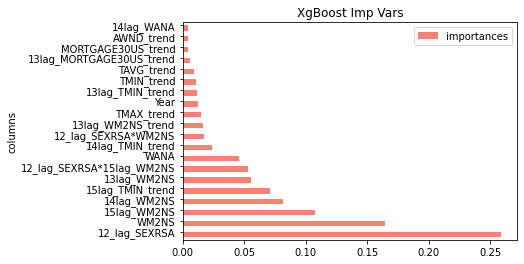

In [27]:
results = pd.concat(appended_feature_imp, axis=0).groupby(['columns'],as_index=False).mean()
results.sort_values(by='importances',ascending=False,inplace=True)
results.iloc[:20,].plot(colormap='Paired',x="columns", y="importances", kind="barh",fontsize = 10,position = 1,color="Salmon")
plt.title("XgBoost Imp Vars")

The best iteration from early stopping is taken from last validation fold, to predict the final 12 month out forecast

In [28]:
xgb_iter

93

In [29]:
final_pred_time = pd.to_datetime(['2020-03-01','2020-04-01','2020-05-01','2020-06-01',
              '2020-07-01','2020-08-01','2020-09-01','2020-10-01',
              '2020-11-01','2020-12-01','2021-01-01','2021-02-01'])


train = df.copy()
train = train[start:]    
for j, column in enumerate(org_data_cols):
    decomp = seasonal_decompose(train[column],freq=12,extrapolate_trend='freq')
    train[f"{column}_trend"] = decomp.trend
    train[f"{column}_seasonal"] = decomp.seasonal

tmp = train.copy()
tmp = tmp.append(pd.DataFrame(index=final_pred_time,columns=train.columns))
for col in tmp.drop(['SEXRSA'], axis=1).columns:
    tmp[col] = tmp[col].shift(fhorizon)        
    
for col in top_features:
    tmp[str(lags[1]) + "lag_" +col] = tmp[col].shift(lags[1])
    tmp[str(lags[2]) + "lag_" +col] = tmp[col].shift(lags[2])
    tmp[str(lags[3]) + "lag_" +col] = tmp[col].shift(lags[3])
    # tmp[str(lags[4]) + "lag_" +col] = tmp[col].shift(lags[4])
    
## Autoregressive components    
for lag in lags:
    tmp[f"{lag}_lag_SEXRSA"] = tmp['SEXRSA'].shift(lag)  

tmp["12_lag_SEXRSA*WM2NS"]  = tmp['12_lag_SEXRSA']*tmp['WM2NS']
tmp["12_lag_SEXRSA*15lag_WM2NS"]  = tmp['12_lag_SEXRSA']*tmp['15lag_WM2NS']
test = tmp.tail(fhorizon); test = add_datetime_features(test)
train = tmp.iloc[fhorizon:-fhorizon]; train = add_datetime_features(train)
train = train.dropna()

print(i)
print('train=',train.shape)
print('test=', test.shape)
data_cols = train.drop(['SEXRSA'], axis=1).columns   
data_cols = sorted(data_cols)
xg = xgb.XGBRegressor(random_state=10,tree_method='gpu_hist',n_estimators=xgb_iter)
xg.fit(train[data_cols],train.SEXRSA.values.ravel(),verbose=True)
test["prediction"] = xg.predict(test[data_cols])
print(test["prediction"].tail(12))
test[["prediction"]].to_csv("Forecasting_results.csv")

352
train= (285, 68)
test= (12, 68)
[18:17:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2020-03-01    258.669556
2020-04-01    258.592682
2020-05-01    258.315613
2020-06-01    257.867767
2020-07-01    256.139160
2020-08-01    257.795166
2020-09-01    249.383911
2020-10-01    249.395920
2020-11-01    255.055283
2020-12-01    255.399155
2021-01-01    255.419098
2021-02-01    255.560120
Name: prediction, dtype: float32
